In [290]:
from blackjack import BlackjackEnv
import numpy as np

In [9]:
import numpy as np

In [45]:
import matplotlib.pyplot as plt

In [35]:
env = BlackjackEnv(natural=True)

### Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 


Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
 - численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
 - туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
 - игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
 - игрок может совершать одно из двух действий:
 - hit  — взять ещё одну карту;
 - stand — не брать больше карт;
 - если сумма очков у игрока на руках больше 21, он проигрывает (bust);
 - если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
 - после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
 - в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).
 
Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 


### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [36]:
def one_game(env):
    state, _ = env.reset()
    while True:
        do = 0 if state[0] >= 19 else 1
        state, reward, stop_game, _, _ = env.step(do)
        if stop_game:
            break
    return reward

In [37]:
def games(env, count):
    sum_reward = 0
    for _ in range(count):
        sum_reward += one_game(env) 
    return sum_reward/ count

In [38]:
def episode(env, count_episode, count_games):
    games_sum_rewards = 0
    for _ in range(count_episode):
        games_sum_rewards +=  games(env, count_games)
    return games_sum_rewards / count_episode

In [39]:
episode(env, 1000, 1000)

-0.18063349999999992

### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.

In [11]:
alpha = 0.003
gamma = 0.06

In [7]:
from collections import defaultdict

In [252]:
Q = defaultdict()

for i in range(2,50):
    Q[i] = {} 
    for k in range(0,11):
        Q[i][k] = {1: 0, 0: 0}
# print(Q)
step = []
rewards = []
avg_rewards = []
stop_game = True
for i in range(1000000):
    state_new, _ = env.reset()
    
    while True:
        state = state_new
        player_score = state[0] 
        diler_score = state[1]
        dict_action = Q[player_score][diler_score]
        if np.random.rand() < 0.1:
            action = np.random.choice(list(dict_action.keys()))
        else: 
            
            action = max(dict_action, key=dict_action.get)
           
        state_new, reward, stop_game, _, _ = env.step(action)

        player_score_new = state_new[0]
        diler_score_new = state_new[1]
        Q[player_score][diler_score][action] = Q[player_score][diler_score][action] + alpha * (reward + gamma * max( Q[player_score_new][diler_score_new].values()) - Q[player_score][diler_score][action])        
        if stop_game:
            break
    rewards.append(reward)
    if i % 50000 ==0 :
        step.append(i)
        avg_rewards.append(np.mean(rewards))



In [253]:
np.mean(rewards)

-0.075122

### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры

In [305]:
reward_sum = 0
for _ in range(10):
    for i in range(100):
        state_new, _ = env.reset()

        while True:
            state = state_new
            player_score = state[0] 
            diler_score = state[1]
            dict_action = Q[player_score][diler_score]
            if np.random.rand() < 0.1:
                action = np.random.choice(list(dict_action.keys()))
            else: 
                action = max(dict_action, key=dict_action.get)
            state_new, reward, stop_game, _, _ = env.step(action)

            player_score_new = state_new[0]
            diler_score_new = state_new[1]
            Q[player_score][diler_score][action] = Q[player_score][diler_score][action] + alpha * (reward + gamma * max( Q[player_score_new][diler_score_new].values()) - Q[player_score][diler_score][action])        
            if stop_game:
                break
        reward_sum += reward

In [306]:
print(f'Казино выиграет: {-1 * reward_sum}')

Казино выиграет: 42.5


Text(0, 0.5, 'Средний выиграш')

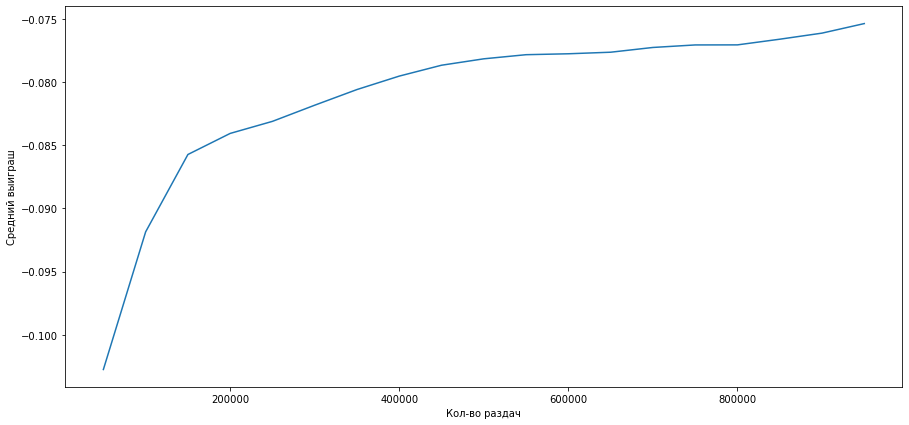

In [307]:
plt.figure(figsize=(15, 7))
plt.plot(step[1:], avg_rewards[1:])
plt.xlabel("Кол-во раздач")
plt.ylabel("Средний выиграш")

Оптимальные гиперпараметры: 
alpha = 0.003
gamma = 0.06

### Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

- double — удвоить ставку; 
- при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.
- Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.
- Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [1]:
from blackjack_with_double import BlackjackEnv

In [2]:
env = BlackjackEnv()

In [39]:
alpha = 0.002
gamma = 0.07

In [77]:
Q = defaultdict()

for i in range(2,50):
    Q[i] = {} 
    for k in range(0,11):
        Q[i][k] = {1: 0, 0: 0, 2:0}
step = []
rewards = []
avg_rewards = []
stop_game = True
for i in range(1000000):
    state_new, _ = env.reset()
    
    while True:
        state = state_new
        player_score = state[0] 
        diler_score = state[1]
        dict_action = Q[player_score][diler_score]
        if np.random.rand() < 0.1:
            action = np.random.choice(list(dict_action.keys()))
        else: 
            
            action = max(dict_action, key=dict_action.get)
           
        state_new, reward, stop_game, _, _ = env.step(action)

        player_score_new = state_new[0]
        diler_score_new = state_new[1]
        Q[player_score][diler_score][action] = Q[player_score][diler_score][action] + alpha * (reward + gamma * max( Q[player_score_new][diler_score_new].values()) - Q[player_score][diler_score][action])        
        if stop_game:
            break
    rewards.append(reward)
    if i % 50000 ==0 :
        step.append(i)
        avg_rewards.append(np.mean(rewards))




In [78]:
np.mean(rewards)

-0.100207

In [91]:
reward_sum = 0
for _ in range(10):
    for i in range(100):
        state_new, _ = env.reset()

        while True:
            state = state_new
            player_score = state[0] 
            diler_score = state[1]
            dict_action = Q[player_score][diler_score]
            if np.random.rand() < 0.1:
                action = np.random.choice(list(dict_action.keys()))
            else: 
                action = max(dict_action, key=dict_action.get)
            state_new, reward, stop_game, _, _ = env.step(action)

            player_score_new = state_new[0]
            diler_score_new = state_new[1]
            Q[player_score][diler_score][action] = Q[player_score][diler_score][action] + alpha * (reward + gamma * max( Q[player_score_new][diler_score_new].values()) - Q[player_score][diler_score][action])        
            if stop_game:
                break
        reward_sum += reward

In [92]:
print(f'Казино выиграет: {-1 * reward_sum}')

Казино выиграет: 44.0


Text(0, 0.5, 'Средний выиграш')

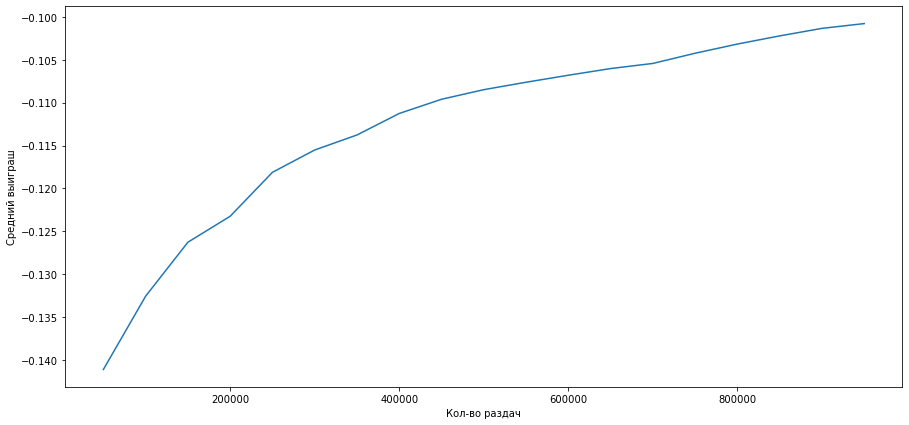

In [93]:
plt.figure(figsize=(15, 7))
plt.plot(step[1:], avg_rewards[1:])
plt.xlabel("Кол-во раздач")
plt.ylabel("Средний выиграш")